<h1>Advanced Analytics with Tree-Based Methods: A Case Study on APS Failure Data</h1>

This comprehensive notebook delves into advanced analytical techniques using tree-based methods, with a specific focus on the APS Failure dataset from Scania Trucks. It offers a detailed exploration of data preparation, feature analysis, and model training with Random Forest and XGBoost classifiers. The notebook is structured to guide the reader through various stages of data analysis, starting from data preparation, handling missing values, and feature selection, to more advanced topics like class imbalance compensation and model trees. Each section is backed by relevant code implementations and visualizations, making it a practical resource for understanding and applying tree-based methods in machine learning.

## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pprint
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import LeaveOneOut, GridSearchCV,StratifiedKFold ,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, auc, accuracy_score
!python -m pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score



warnings.filterwarnings('ignore')

### Download the APS Failure data

In [2]:
APSFailure_train_df = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20, na_values='na')
APSFailure_test_df = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20, na_values='na')
print("Training Data Shape: ", APSFailure_train_df.shape)
print("Testing Data Shape: ", APSFailure_test_df.shape)

APSFailure_desc = '../data/aps_failure_description.txt'

Training Data Shape:  (60000, 171)
Testing Data Shape:  (16000, 171)


In [3]:
APSFailure_train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
APSFailure_test_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


### Data Preparation

#### Research what types of techniques are usually used

- Data Dropping / Deletion - Completely remove rows or columns containing missing values. This should only be done when the amount of missing data is small. Using the dropna() function is the easiest way to remove observations or features with missing values from the dataframe. 
- Imputation - Replace missing values with a placeholder value such as the mean, median, or mode of the column. Simple imputation methods can cause bias.
    - Mean/Median Imputation: used to replace missing values of a given column with the mean and median of the non-missing values in that column. In Python, the fillna() function from pandas can be used to make these replacements.
    - Random Sample Imputation: different from the previous ones and involves additional steps. 
- Model-based imputation - Use regression or machine learning models to predict missing values based on other variables. Requires more complex modeling.
- Multivariate imputation - Impute missing values while accounting for correlations between variables. Methods include MICE (Multivariate Imputation by Chained Equations).
- Indicator variables - Add a binary column indicating missing/not missing for each variable with missing data. Allows missing values to be handled in analysis.

reference: https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

For this data set, I would try simple imputation methods first by replacing missing values with the mean or median for that column. This preserves more of the data compared to deletion. Model-based imputation could also be effective if relationships between variables are accounted for in the modeling. 

In [5]:
def split_data(df, x_columns=None, y_columns=None):
    if x_columns is None:
        x_data = df.iloc[:, 1:]  # Default: All columns except the first
    else:
        x_data = df[x_columns]

    if y_columns is None:
        y_data = df.iloc[:, 0:1]  # Default: The first column
    else:
        y_data = df[y_columns]

    return x_data, y_data

In [6]:
X_train, y_train = split_data(APSFailure_train_df)
X_test, y_test = split_data(APSFailure_test_df)

print("Training Data Features Shape: ", X_train.shape)
print("Training Data Label Shape: ", y_train.shape)
print("Test Data Features Shape: ", X_test.shape)
print("Test Data Label Shape: ", y_test.shape)

Training Data Features Shape:  (60000, 170)
Training Data Label Shape:  (60000, 1)
Test Data Features Shape:  (16000, 170)
Test Data Label Shape:  (16000, 1)


Replacing missing values with the mean: 

In [7]:
def missing_impute(df, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy, missing_values=np.nan)
    temp1 = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(temp1, columns=df.columns)
    return imputed_df

In [8]:
X_train_df = missing_impute(X_train)
X_test_df = missing_impute(X_test)

In [9]:
X_train_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [10]:
X_test_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


check whether there is still any missing values 

In [11]:
missing_values = X_train_df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values in X_train_df:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in X_train_df")

No missing values in X_train_df


In [12]:
missing_values = X_test_df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values in X_test_df:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in X_test_df")

No missing values in X_test_df


#### Calculate the coefficient of variation

For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [13]:
def calculate_cv_df(df):
    # mean and standard deviation for each column
    mean_values = df.mean()
    std_values = df.std()

    # coefficient of variation (CV)
    cv_values = std_values / mean_values

    # create a DataFrame for CV values
    cv_df = pd.DataFrame({'Coeff_CV': cv_values})
    
    return cv_df

In [14]:
cv_df = calculate_cv_df(X_train_df)
cv_df_sorted = cv_df['Coeff_CV'].sort_values(ascending=False)
cv_df_sorted

cs_009    235.277605
cf_000    184.233092
co_000    183.949017
ad_000    183.847620
dh_000    114.984991
             ...    
bo_000      0.462564
bp_000      0.425967
bq_000      0.399192
br_000      0.382669
cd_000      0.000000
Name: Coeff_CV, Length: 170, dtype: float64

#### Plot a correlation matrix

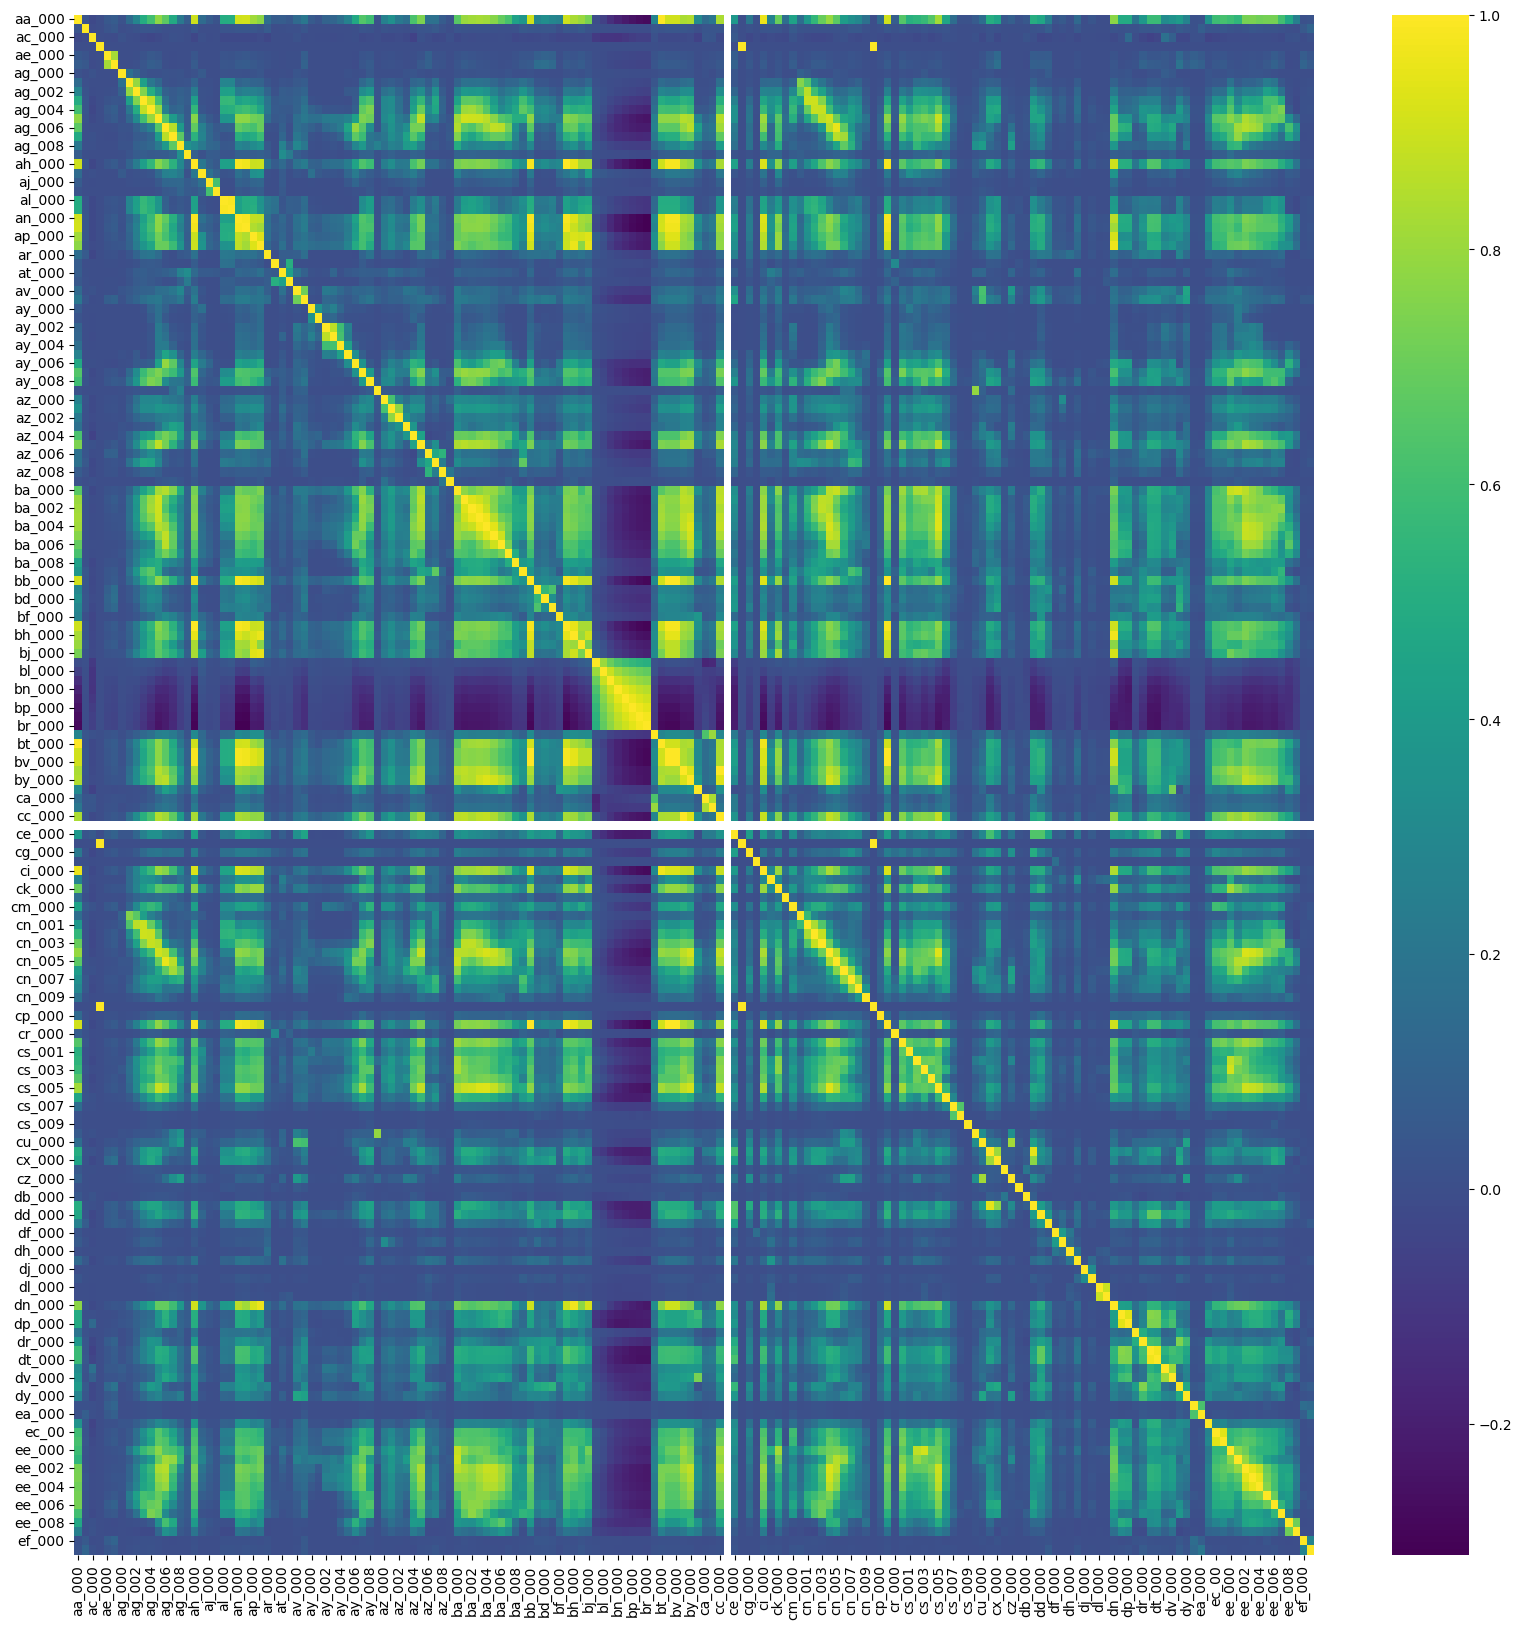

In [15]:
plt.figure(figsize=(20, 20))
corr = X_train_df.corr()
sns.heatmap(corr, cmap="viridis")
plt.show()

#### Make scatter plots and box plots

Pick the square root of 170 features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about
signi cance of those features, just by the scatter plots? This does not mean
that you will only use those features in the following questions. We picked
them only for visualization.

In [16]:
def select_highest_cv_features(cv_df, num_features):
    return cv_df.index[:num_features].tolist()

def plot_pairplot(df, features):
    sns.pairplot(df[features], diag_kind=None)
    plt.show()

def plot_box_plots(df, features):
    fig, axes = plt.subplots(figsize=(12, 7))
    box = sns.boxplot(data=df[features], ax=axes, orient='h')
    box.set(xscale="log")
    plt.show()

In [17]:
# Select the top features with the highest CV
num_features_to_select = int(np.sqrt(170))
highest_cv_features = select_highest_cv_features(cv_df_sorted, num_features_to_select)

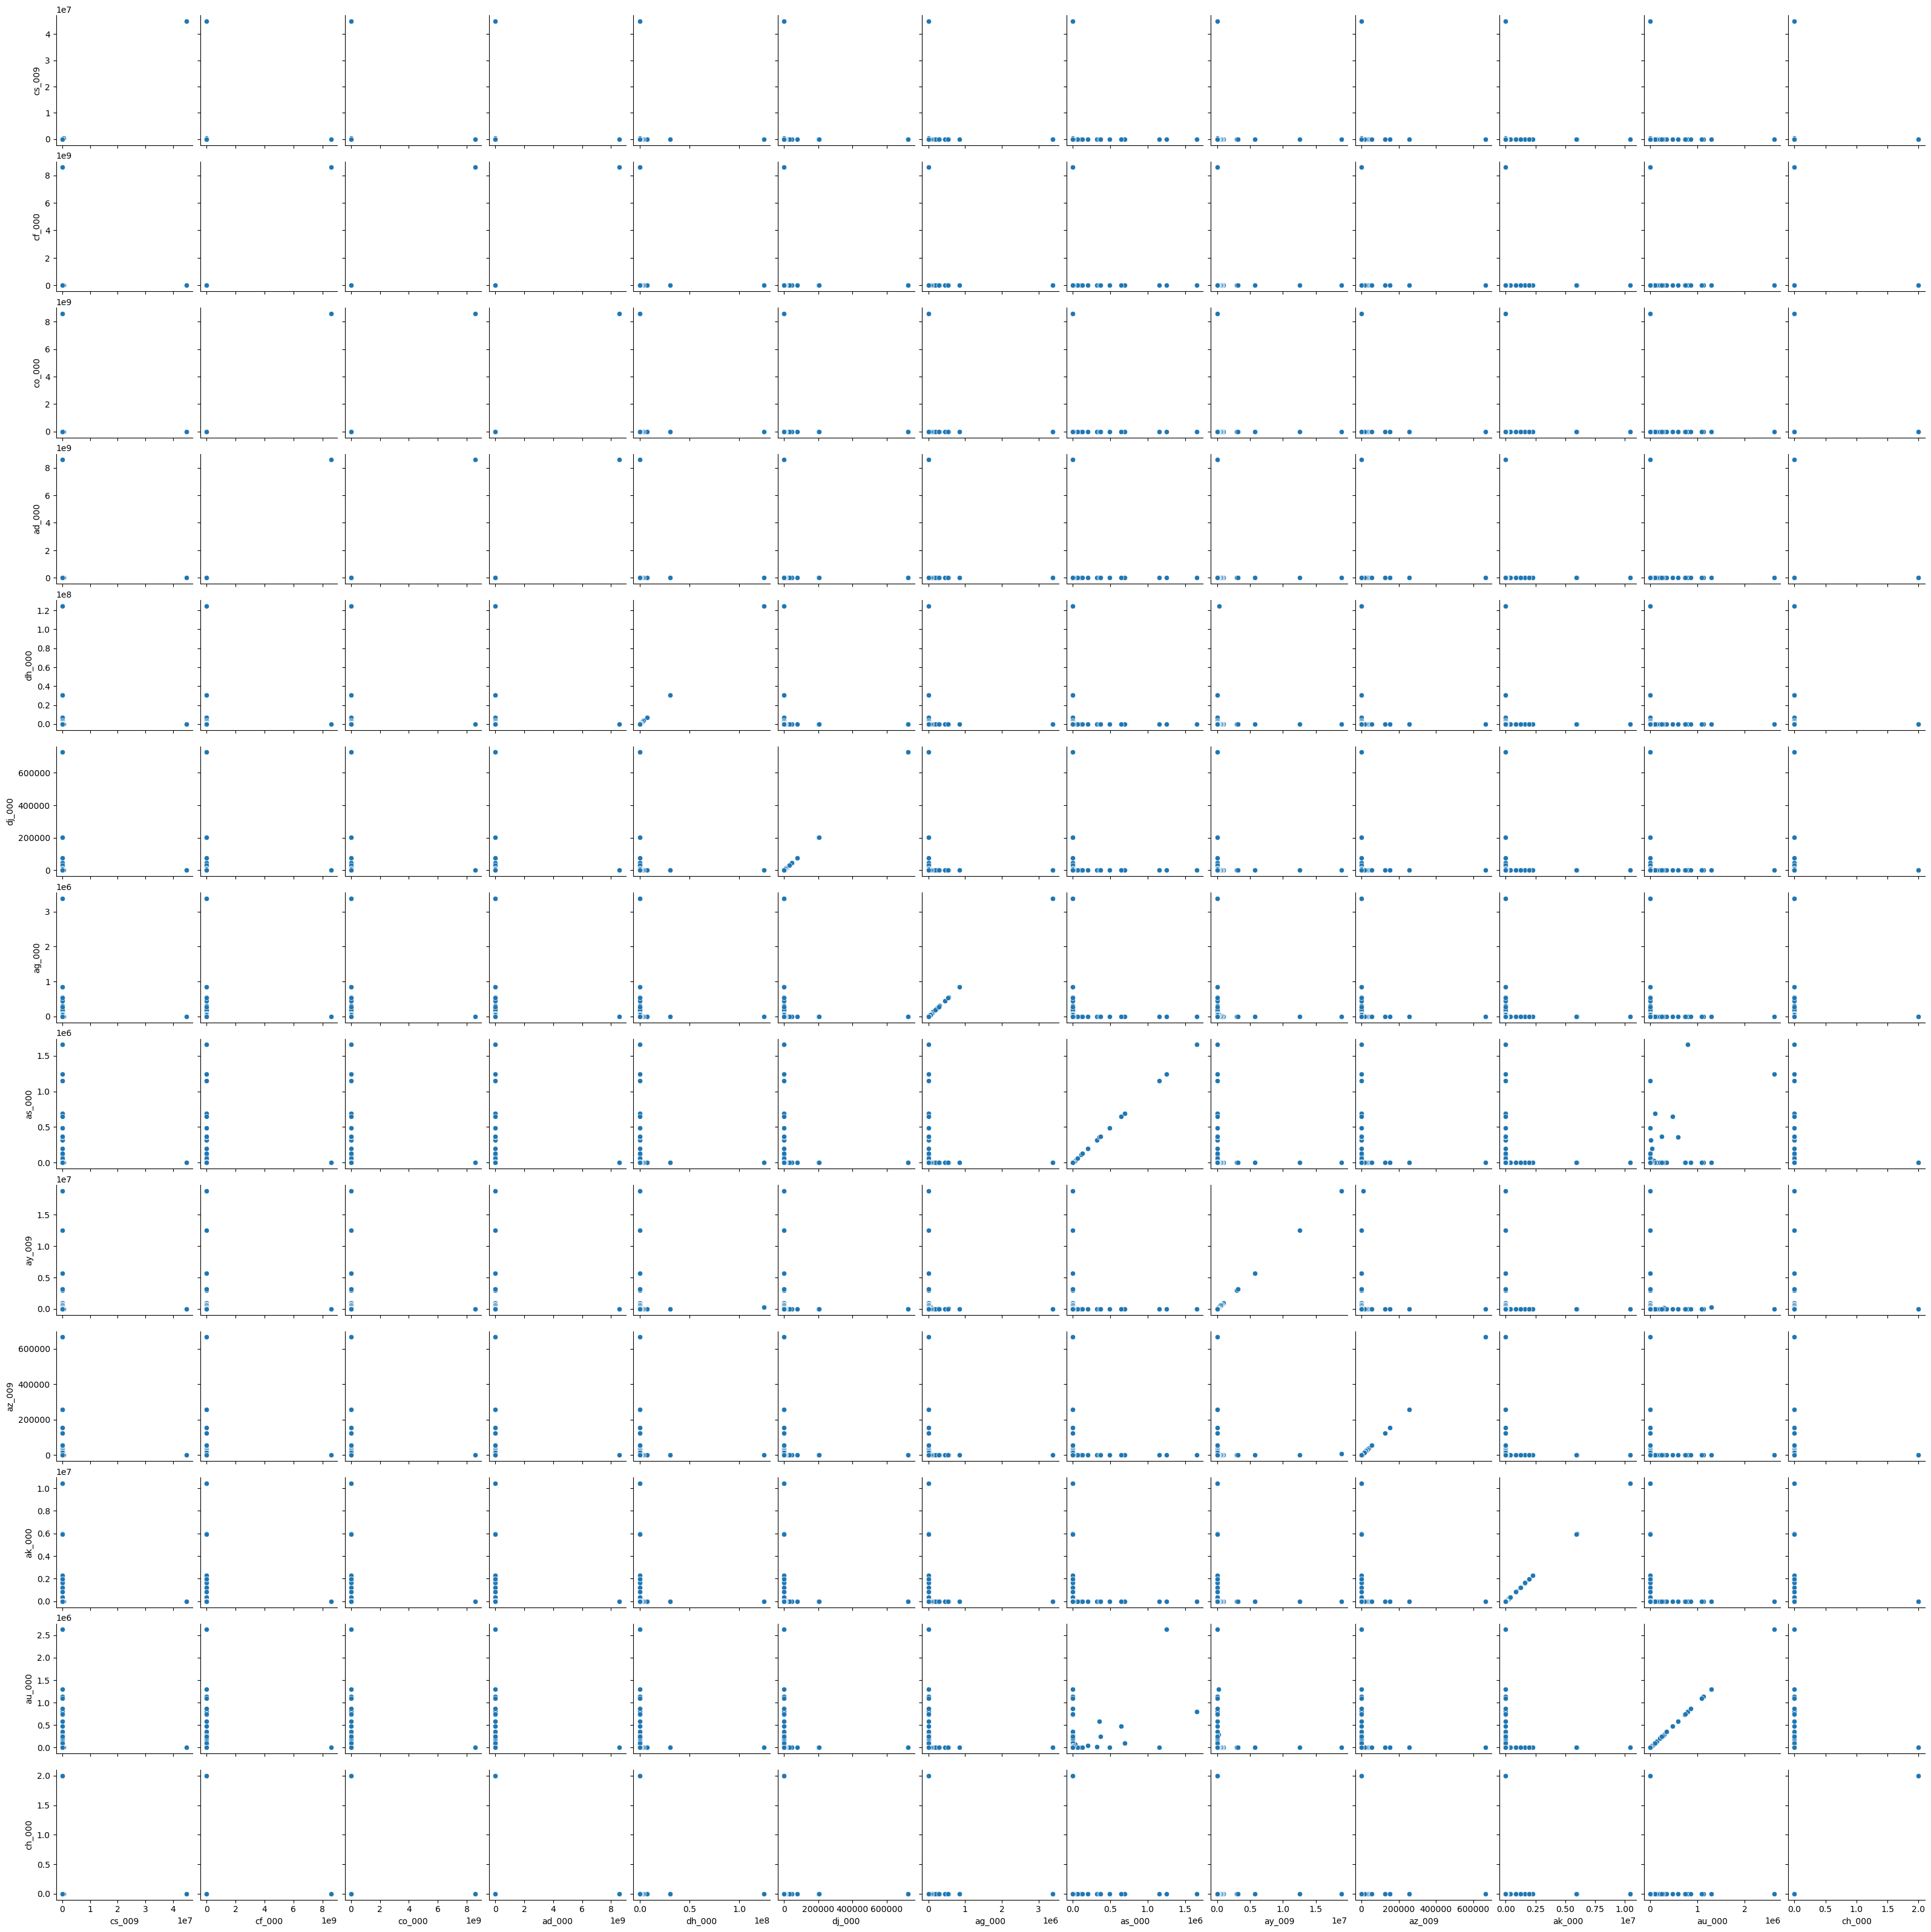

In [18]:
# Plot pairplots for selected features
plot_pairplot(X_train_df, highest_cv_features)

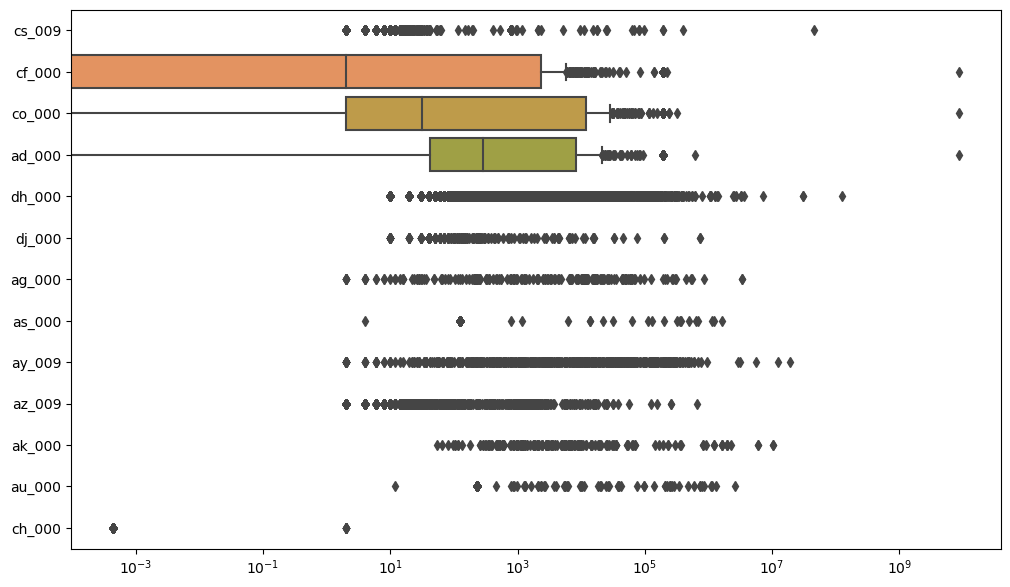

In [19]:
# Plot box plots for selected features
plot_box_plots(X_train_df, highest_cv_features)

Drawing conclusions about the significance of features based solely on scatter plots can be somewhat limited. The scatter plot here may not reveal the full story if there are any outliers since the outliers can have a significant impact on correlation. 

In [20]:
y_train.value_counts()

class
neg      59000
pos       1000
Name: count, dtype: int64

In [21]:
y_test.value_counts()

class
neg      15625
pos        375
Name: count, dtype: int64

Based on the big differences in the number of positives and negatives, we can tell both the training and testing datasets are imbalanced. 

### Train a random forest

In [22]:
def calculate_metrics(ground_truth, predicted_truth, prob=None, title=None, is_for_xgboost=False):
    conf_matrix = confusion_matrix(ground_truth, predicted_truth)
    accuracy = accuracy_score(ground_truth, predicted_truth)
    
    if is_for_xgboost:
        roc_auc = roc_auc_score(ground_truth, predicted_truth)
        print(f'ROC AUC Score is: {round(roc_auc, 4)}')
    
    print(f'Accuracy Score is: {round(accuracy, 4)}')
    print(f'Confusion Matrix is:\n{conf_matrix}\n')
    
    if prob is not None:
        plot_roc_curve(ground_truth, prob, title, is_for_xgboost)

def plot_roc_curve(actualY, predictedY_prob, title, is_for_xgboost=False):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title(f"ROC curves for {title}")
    y_predicted = predictedY_prob[:, 1]
    if not is_for_xgboost:
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label='pos')
    else:
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label=f"ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

def fit_random_forest(data_x, data_y, is_balanced=False):
    if not is_balanced:
        RF_model = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True)
    else:
        RF_model = RandomForestClassifier(max_depth=5, random_state=60000, class_weight='balanced', oob_score=True)
    RF_model.fit(data_x, data_y)
    return RF_model

Accuracy Score is: 0.992
Confusion Matrix is:
[[58972    28]
 [  450   550]]



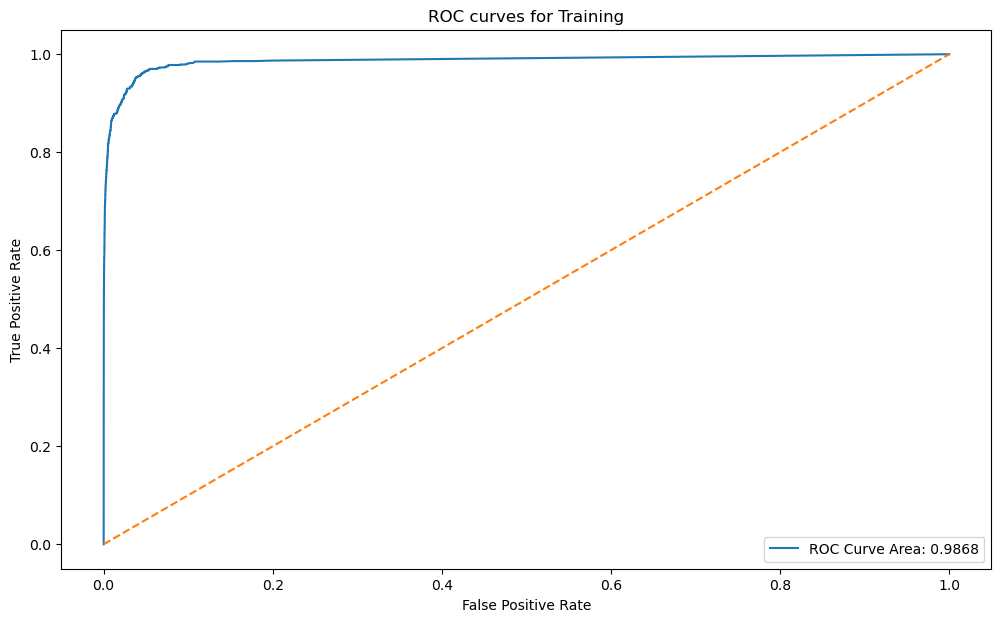

In [23]:
# Calculate and display metrics for training data
RF_model = fit_random_forest(X_train_df, y_train)
train_y_predicted = RF_model.predict(X_train_df)
train_y_prob = RF_model.predict_proba(X_train_df)
calculate_metrics(y_train, train_y_predicted, train_y_prob, "Training")

Accuracy Score is: 0.9879
Confusion Matrix is:
[[15612    13]
 [  180   195]]



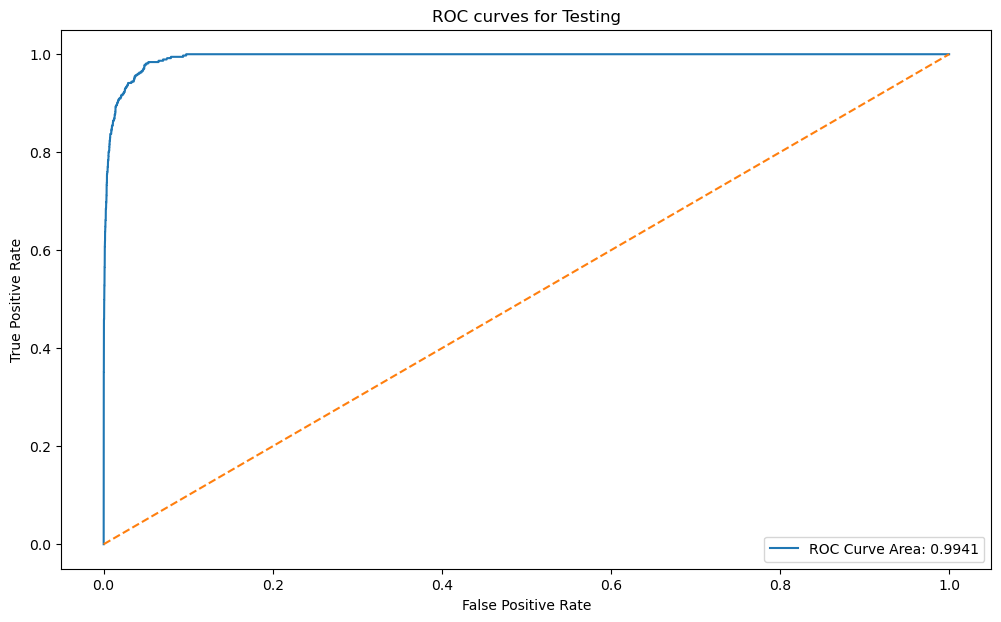

In [24]:
# Calculate and display metrics for testing data
test_y_predicted = RF_model.predict(X_test_df)
test_y_prob = RF_model.predict_proba(X_test_df)
calculate_metrics(y_test, test_y_predicted, test_y_prob, "Testing")

In [25]:
# OOB error and testing error
train_oob_error = 1 - RF_model.oob_score_
test_error = 1 - accuracy_score(y_test, test_y_predicted)

data = {
    'Training OOB Error': [round(train_oob_error, 4)],
    'Testing Error': [round(test_error, 4)]
}
data = pd.DataFrame(data=data)
data

,Training OOB Error,Testing Error
0,0.0094,0.0121


Ways to address class imbalance when using Random Forests:

- Stratified Sampling: When splitting the dataset into training and testing subsets, ensure that each class is proportionally represented in both sets. This is known as stratified sampling. Many machine learning libraries, including scikit-learn, provide options for performing stratified sampling.

- Class Weight Balancing: Random Forests allow you to assign different weights to classes using the class_weight parameter. By assigning higher weights to the minority class and lower weights to the majority class, the algorithm pays more attention to the minority class during training.

- Over-sampling: You can increase the number of samples in the minority class by creating synthetic samples. This can be done through techniques like SMOTE (Synthetic Minority Over-sampling Technique), which generate synthetic examples to balance the class distribution.

- Under-sampling: Reduce the number of samples in the majority class to balance the class distribution. This can be achieved by randomly selecting a subset of the majority class samples. However, be cautious when using under-sampling, as it may lead to information loss.

- Anomaly Detection: If the class imbalance is extreme, you can treat the problem as an anomaly detection task. Instead of trying to balance the classes, you can focus on identifying the minority class as anomalies or outliers.

- Threshold Tuning: Adjust the classification threshold to make the model more or less sensitive to the minority class. By lowering the threshold, you can increase recall (sensitivity) for the minority class, but this may result in more false positives.

- Ensemble Techniques: Combining multiple models can be helpful. For example, you can use techniques like EasyEnsemble, BalanceCascade, or SMOTEBoost, which are ensemble methods designed to address class imbalance.

In [26]:
def calculate_confusion_matrix(ground_truth, predicted_truth):
    conf_matrix = confusion_matrix(ground_truth, predicted_truth)
    print(f'Confusion Matrix is: \n{conf_matrix}')
    print("\n")


In [27]:
def get_roc_auc_score(ground_truth, predicted_truth):
    calculated_roc_auc_score = roc_auc_score(ground_truth, predicted_truth)
    print(f'ROC AUC Score is: {round(calculated_roc_auc_score, 4)}')
    print("\n")

In [28]:
def calculate_model_summary(ground_truth, predicted_truth, prob, title, is_for_xgboost=False):
    calculate_accuracy_score(ground_truth, predicted_truth)
    calculate_confusion_matrix(ground_truth, predicted_truth)
    if is_for_xgboost:
        get_roc_auc_score(ground_truth, predicted_truth)
    plot_roc_curve(ground_truth, prob, title, is_for_xgboost)

In [29]:
def calculate_accuracy_score(ground_truth, predicted_truth):
    calculated_accuracy_score = accuracy_score(ground_truth, predicted_truth)
    print(f'Accuracy Score is: {round(calculated_accuracy_score, 4)}')
    print("\n")


Accuracy Score is: 0.9589


Confusion Matrix is: 
[[56563  2437]
 [   31   969]]




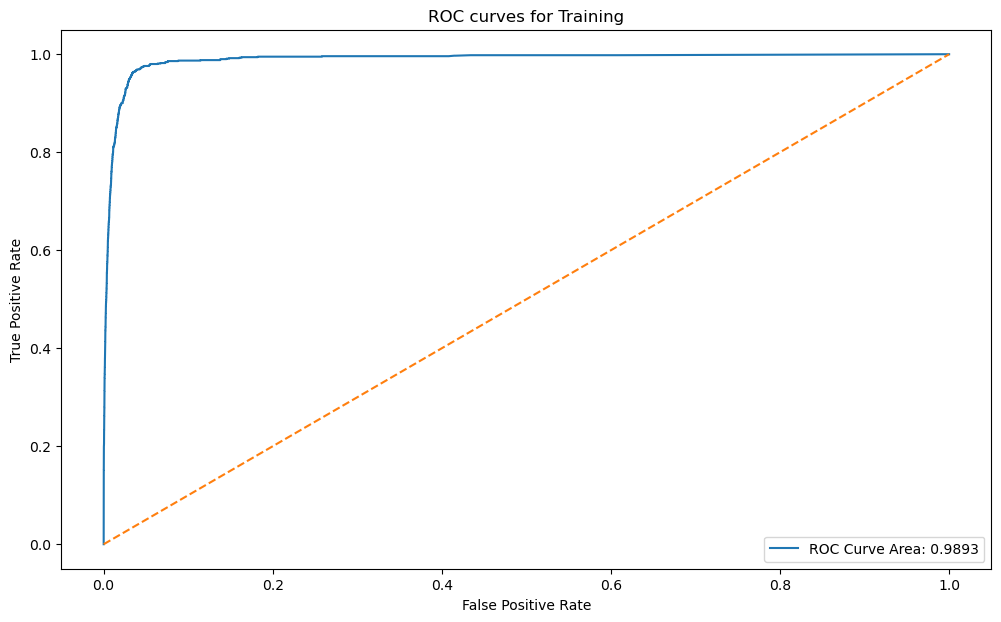

In [30]:
RF_model = fit_random_forest(X_train_df, y_train, is_balanced=True)
train_y_predicted_2 = RF_model.predict(X_train_df)
train_y_prob_2 = RF_model.predict_proba(X_train_df)
calculate_model_summary(y_train, train_y_predicted_2, train_y_prob_2, "Training")

Accuracy Score is: 0.9595


Confusion Matrix is: 
[[14992   633]
 [   15   360]]




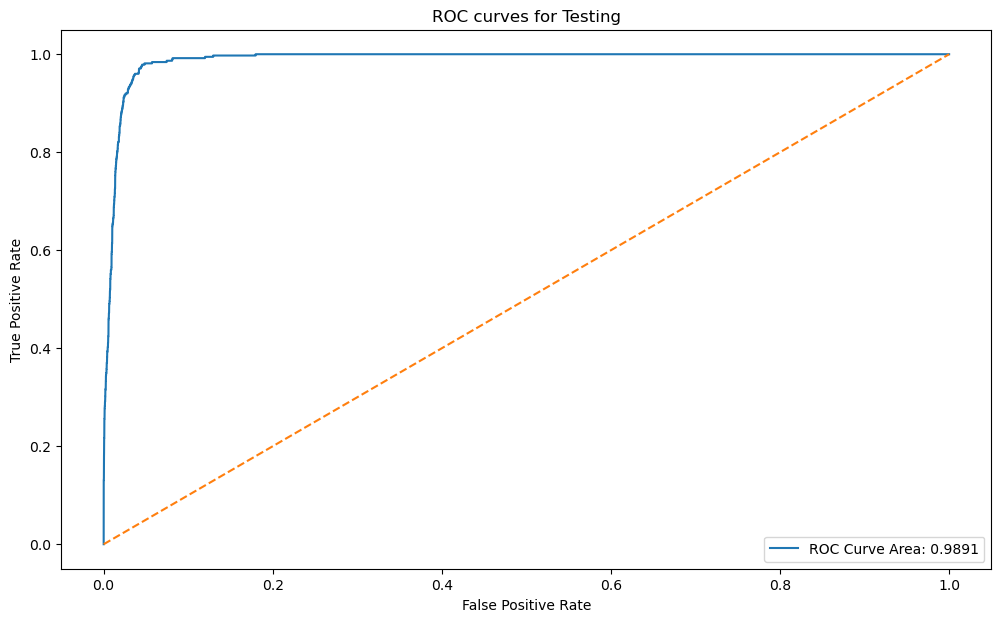

In [31]:
test_y_predicted_2 = RF_model.predict(X_test_df)
test_y_prob_2 = RF_model.predict_proba(X_test_df)
calculate_model_summary(y_test, test_y_predicted_2, test_y_prob_2, "Testing")

In [32]:
# calculating oob error
train_oob_error_2 = 1 - RF_model.oob_score_
test_error_2 = 1 - accuracy_score(y_test, test_y_predicted_2)

data = {
    'Training OOB Error': [round(train_oob_error_2, 4)],
    'Testing Error': [round(test_error_2, 4)]
}
data = pd.DataFrame(data=data)
data

,Training OOB Error,Testing Error
0,0.0424,0.0405


By compensating for the class imbalance, the training OOB error and testing error are both higher than the case when we did not compensate for class imbalance.

### XGBoost and Model Trees

In [33]:
ss = StandardScaler()
train_x_cols = X_train_df.columns
test_x_cols = X_test_df.columns
x_train = pd.DataFrame(ss.fit_transform(X_train_df),columns=train_x_cols)
x_test = pd.DataFrame(ss.fit_transform(X_test_df),columns=test_x_cols)


In [34]:
estimator = XGBClassifier(objective='binary:logistic',
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False)
param_grid = {
    "reg_alpha": [0.01, 0.05,0.07,0.08,0.09, 0.1, 0.2, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200]
}

In [35]:
y_test['class'].replace({'neg':0,'pos':1},inplace=True)
y_train

,class
0,neg
1,neg
2,neg
3,neg
4,neg
...,...
59995,neg
59996,neg
59997,neg
59998,neg


In [36]:
import warnings

# Suppress all DeprecationWarnings and FutureWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress all warnings that contain a specific text
warnings.filterwarnings("ignore", message="Some specific text")

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



In [37]:
cv = KFold(n_splits=5, shuffle=True, random_state=11)
grid_cv = GridSearchCV(estimator,
                       param_grid,
                       n_jobs=-1,
                       cv=cv,
                       scoring="accuracy")
y_train['class'].replace({'neg': 0, 'pos': 1}, inplace=True)
grid_cv.fit(x_train, y_train)

/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or

GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2,
                                       0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50,
                                       100, 200]},
             scoring='accuracy')

the above code has a lot of FutureWarning, which was not able to be avoided, but if you scroll down to the bottom, you can see the model is successfully built and the model information is successfully printed out 

In [38]:
print('The best alpha is ',grid_cv.best_params_, ' with a cross validation accuracy of ',round(grid_cv.best_score_,4))

The best alpha is  {'reg_alpha': 0.2}  with a cross validation accuracy of  0.9941


In [39]:
alpha = grid_cv.best_params_['reg_alpha']
estimator = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
estimator.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
y_train_pred = estimator.predict(x_train)
y_train_pred_prob = estimator.predict_proba(x_train)

y_test_pred = estimator.predict(x_test)
y_test_pred_prob = estimator.predict_proba(x_test)

Accuracy Score is: 0.9982


Confusion Matrix is: 
[[58994     6]
 [  104   896]]


ROC AUC Score is: 0.9479




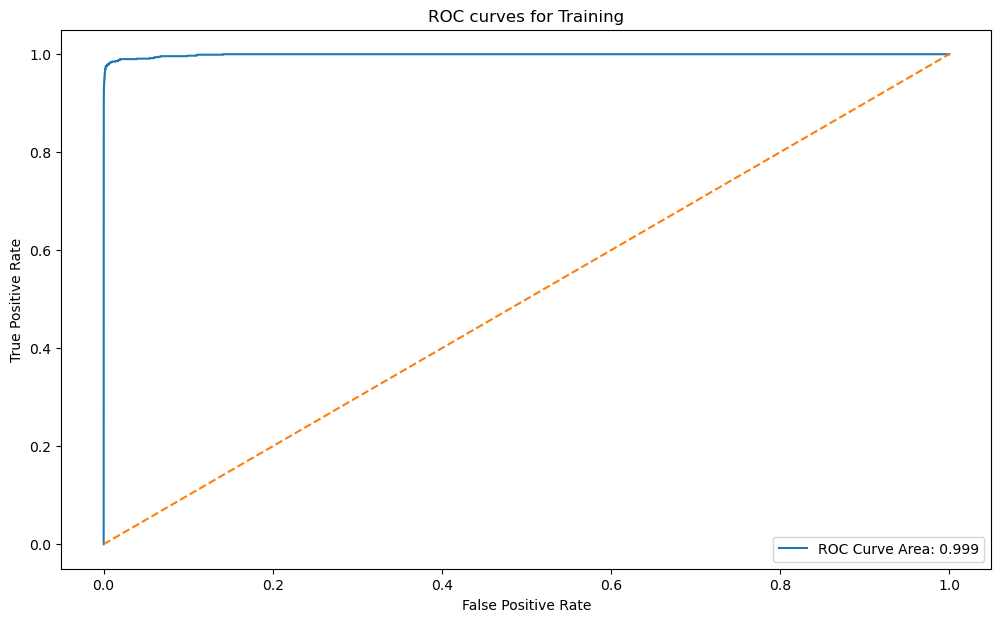

In [41]:
calculate_model_summary(y_train.values, y_train_pred, y_train_pred_prob, "Training", is_for_xgboost=True)

Accuracy Score is: 0.9909


Confusion Matrix is: 
[[15590    35]
 [  111   264]]


ROC AUC Score is: 0.8509




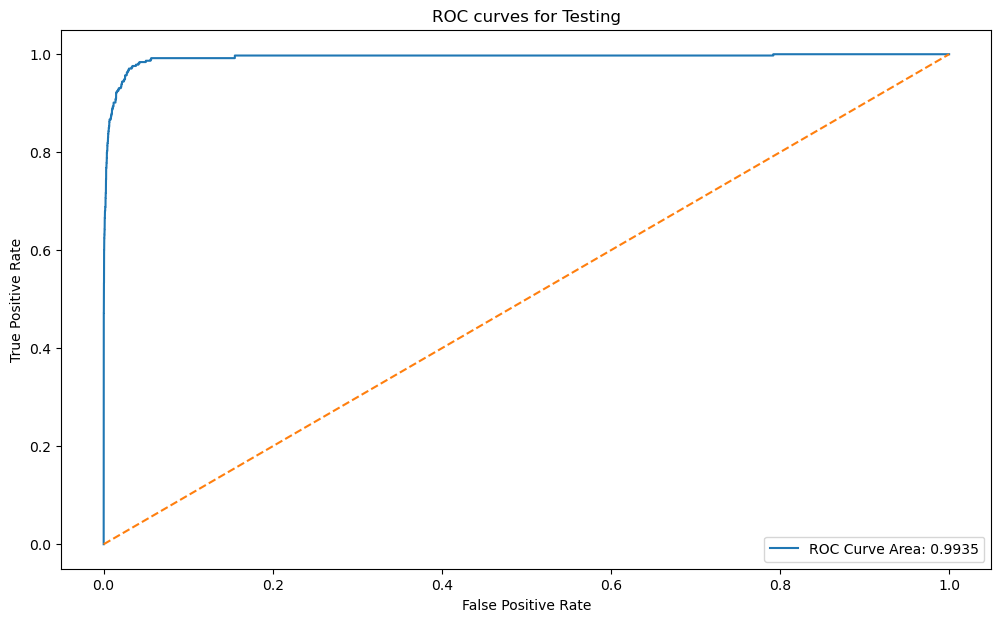

In [42]:
calculate_model_summary(y_test, y_test_pred, y_test_pred_prob, "Testing", is_for_xgboost=True)

### Use SMOTE to pre-process your data

In [43]:
# set up the Synthetic Minority Over-sampling Technique
smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

In [44]:
# check how the data are changed after the application of the technique
smote_data = {
    "Before SMOTE": y_train.value_counts(),
    "After SMOTE": y_train_SMOTE.value_counts()
}

smote_compare_df = pd.DataFrame(data=smote_data)
smote_compare_df

,Before SMOTE,After SMOTE
class,,
0,59000,59000
1,1000,59000


In [45]:
# double check the estimator we have 
estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [46]:
cv = KFold(n_splits=5,shuffle=True,random_state=11)
grid_smote = GridSearchCV(estimator, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=cv, 
                       scoring="accuracy")
grid_smote.fit(X_train_SMOTE, y_train_SMOTE)

/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/cicichang/anaconda3/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or

GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2,
                                       0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50,
                                       100, 200]},
             scoring='accuracy')

the above code has a lot of FutureWarning, which was not able to be avoided, but if you scroll down to the bottom, you can see the model is successfully built and the model information is successfully printed out 

In [48]:
print('The best alpha is ',grid_smote.best_params_, ' with a cross validation accuracy of ',round(grid_smote.best_score_,4))

The best alpha is  {'reg_alpha': 0.08}  with a cross validation accuracy of  0.9945


In [49]:
alpha_value = grid_smote.best_params_['reg_alpha']

estimator_smote = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha_value,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
y_train['class'].replace({'neg':0,'pos':1},inplace=True)
estimator_smote.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
y_train_pred = estimator_smote.predict(x_train)
y_train_pred_prob = estimator_smote.predict_proba(x_train)

y_test_pred = estimator_smote.predict(x_test)
y_test_pred_prob = estimator_smote.predict_proba(x_test)

Accuracy Score is: 0.9982


Confusion Matrix is: 
[[58995     5]
 [  102   898]]


ROC AUC Score is: 0.949




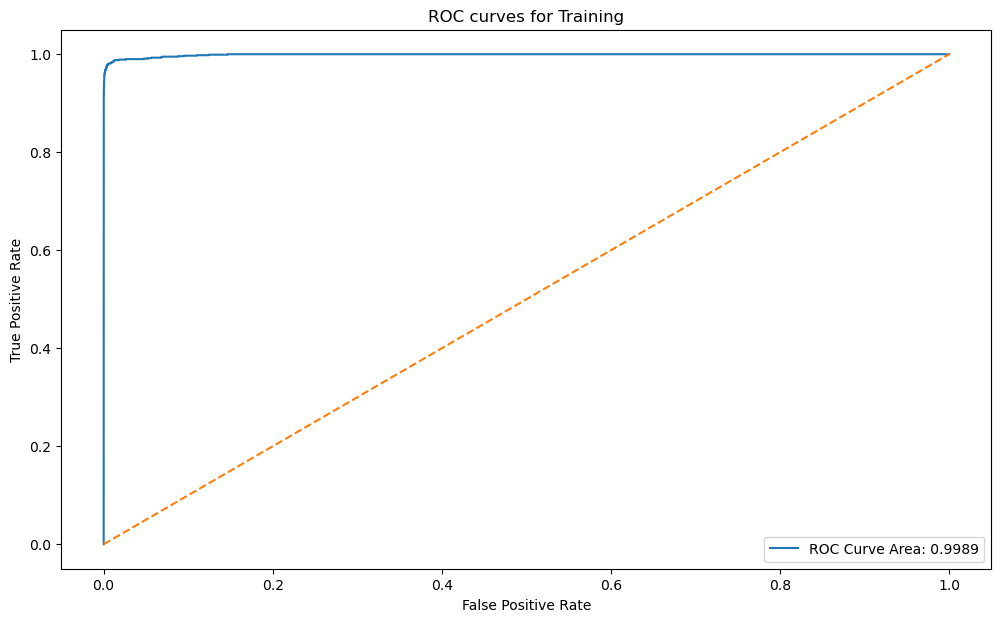

In [51]:
calculate_model_summary(y_train.values, y_train_pred, y_train_pred_prob, "Training", is_for_xgboost=True)

Accuracy Score is: 0.9915


Confusion Matrix is: 
[[15597    28]
 [  108   267]]


ROC AUC Score is: 0.8551




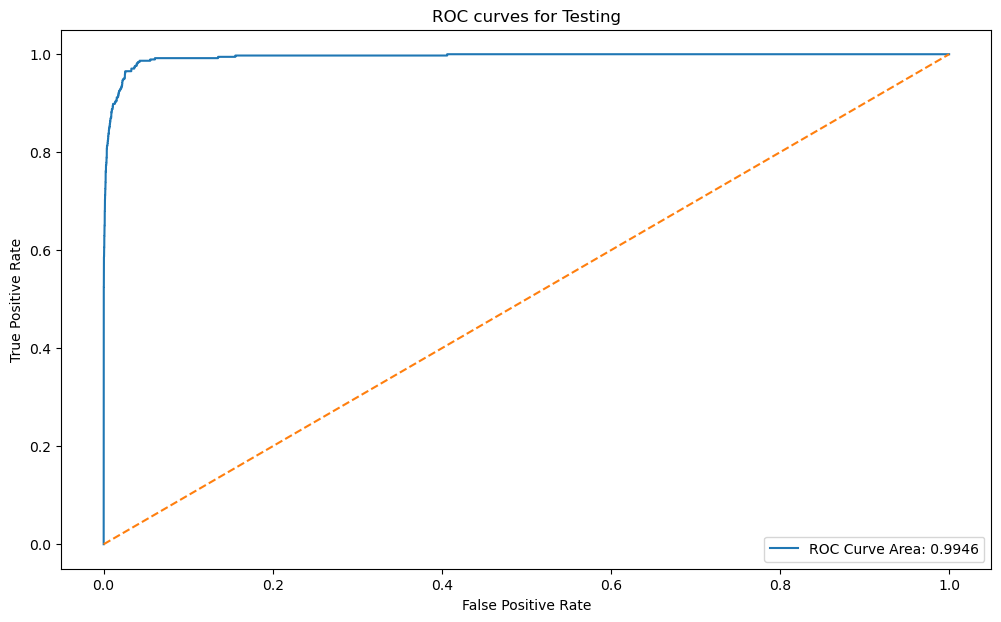

In [52]:
calculate_model_summary(y_test, y_test_pred, y_test_pred_prob, "Testing", is_for_xgboost=True)